# Brief Background on Aerosol

Aerosol (sometimes called particulate matter) are more than just Aquanet! They are any kind of small, liquid or solid particles suspended in air. Types of aerosol include clouds, haze, pollen, dust, and smoke. In general, scientists care about aerosol because many types of aerosol (like smoke) are harmful when inhaled. Organic (meaning carbon-containing) aerosol, one such potentially harmful type of aerosol, are tiny balls of oil or wax suspended in air. They are produced from automobile exhaust (as part of smog) or the chemicals that trees and other plants emit. 

As these particles float through the air, oxidants from the surrounding gas can collide with the surface and cause chemical reactions. One important oxidant is the hydroxyl (OH) radical, which is produced from ground level ozone, water vapor, and UV light. After colliding with the surface of an aerosol, this highly reactive chemical can launch a series of chemical reactions throughout the aerosol. Because organic aerosol exist as both liquids and solids, though, how deeply oxidants and other reactive chemicals can penetrate into the aerosol can vary greatly. 



# Simulations and Data Analysis

This notebook demonstrates the data processing of simulations (validated from experimental data) used to investigate the oxidation of organic aerosol. The oxidation of four different generic organic materials by OH radicals with different consistencies are investigated. The oxidation of these aerosol is simulated for a laboratory reactor. This reactor is designed to simulate one week of atmospheric oxidation in 60 seconds. In order from most liquid-like to most solid-like, the first has the consitency of ketchup, the second has the consistency of peanut butter, the third has the consistency of lard, and the fourth has the consistency of caulk. In the more solid-like materials, chemicals within the aerosol move more slowly than more liquid-like aerosol. 

The spherical aerosol is represented as a stack of boxes as shown in the following figure: ![](sim_summary.png)

Because of the change in geometry, the data have to be postprocessed so that the outer box is weighted more than the inner most box. In other words, each box is considered equivalent to a spherical "layer" within the the sphere.



## Loading the data

First, the simulation data are unzipped and put into a subdirectory. Then, they are parsed using minidom in the Python XML package. These data are then loaded into custom Python classes representing the simulation and each box/compartment. (See /python/StackSim.py for more details.)

In [1]:
# Contains classes for compartments and simulations
import python.StackSim as StackSim

# Load in python modules used in notebook
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler




In [2]:
# Create system-independent subdirectory

subdir = os.path.join(os.path.curdir, "demodata")

# Unzip to subdirectory

with zipfile.ZipFile("demodata.zip", "r") as zip_ref:
    zip_ref.extractall(subdir)
    
# Associate each simulation XML file to a string

simulation_files = {"Ketchup" : "tri_ft_D11.xml", 
                    "Peanut Butter" : "tri_ft_D12.xml",
                    "Lard" : "tri_ft_D13.xml",
                    "Caulk" : "tri_ft_D14.xml"}

In [3]:
# Initialize dictionary for each simulation
simulations = dict()

# Generate simulation and comaprtment objects for each simulation
for simulation, file in simulation_files.items():
    # See StackSim.py for more details on how the file is processed
    simulations[simulation] = StackSim.SimulationData(os.path.join(subdir, file))
    

## Data processing

In these simulations, a linear hydrocarbon, triacontane (C<sub>30</sub>H<sub>62</sub>), is represented an independent set of two methyl groups (-CH<sub>3</sub>, three hydrogen atoms bonded to one carbon atom) and twenty eight methylene groups (-CH<sub>2</sub>-, two hydrogen atoms bonded to one carbon atom). Each of these groups can react or move around the aerosol independently from each other. New groups form as the aerosol react, such as ketone (-C=O-, a carbon atom in a double bond with oxygen) groups. In addition to the reactions of groups, each carbon backbone from C1 to C30 is considered an independent species. By representing the molecule as a collection of independent groups and carbon backbones, the number of species needed to describe the oxidation decreases from over 100,000 to just 350. 

Because we represented the system this way, we need to process the resulting data to obtain properties that are actually measured in aerosols from experiments or the atmosphere. One common measurement of organic aerosols is the oxygen-to-carbon (O/C) ratio. To find this from our simulation results, we multiply each group by the number of oxygen or carbon atoms and add them up. For example, we would multiply a ketone group (C=O) by one when finding the number of oxygen atoms and multiply a C24 group by 24 when finding the number of carbon atoms. A contour map of the O/C ratio is also created so we can explore where the aerosol is more oxidized.



In [4]:
# Generate lists for finding weighting aggregate species from individual
# functional group or carbon backbone species

carbon_min, carbon_max = 1, 30

missing_carbon_no = [1, 30]

# Create carbon-30 lumped species from each component

carbon_no_dict = {"nC30" : [["C30", 1], ["C30_COOH", 1], ["C30_COOH_O", 1], ["C30_HOOCCOOH", 1], ["C30_O2", 1], ["C30_O", 1]]}

# Initialize list of lists

carbon_list = [["nC30", 30]]

for i in range(carbon_min, carbon_max+1, 1):
    if i in missing_carbon_no:
        pass
    else:
        no_C = "C"+str(i)
        
        # Add entry to lumped carbon number dictionary
        carbon_no_dict["n"+no_C] = [[no_C, 1], [no_C+"_O2", 1], [no_C+"_COOH", 1], [no_C+"_COOH_O", 1], [no_C+"_HOOCCOOH", 1]]
        
        # Add entry to list of list for carbon number weighting
        carbon_list.append(["n"+no_C, i])

# Generate oxygen species weighting list

oxygen_list = [["OC_sec", 1], ["OCH_prim", 1], ["OHCH2_prim", 1], ["OHCH_sec", 1],
               ["OC_alpha", 1], ["OHCH_alpha", 1], ["HO_OOC_prim", 3],
               ["HOOCH2_prim", 2], ["HOOCH_alpha", 2], ["HOOCH_sec", 2], ["HOOC_prim", 2]]

In [5]:
# Process data from each simulation to find O/C ratio

for name, simulation in simulations.items():
    
    # Calculate aggregate carbon species and radial correction
    for carbon_no in carbon_no_dict.keys():
        simulation.calcAggregateSpecies(carbon_no, carbon_no_dict[carbon_no])
        simulation.calcRadialCorrection(carbon_no, reverse_axis=True)

    # Calculate each total of oxygen and carbon
    simulation.calcAggregateSpecies("carbon", carbon_list)

    simulation.calcAggregateSpecies("oxygen", oxygen_list)
    
    # Find radial correction for each species
    
    simulation.calcRadialCorrection("carbon", reverse_axis=True)
    
    simulation.calcRadialCorrection("oxygen", reverse_axis=True)
    
    # Find O/C ratio
    simulation.calcSpeciesRatio("O/C ratio", "oxygen_r", "carbon_r")
    
    # Create contour map of O/C ratio by interpolating over compartments
    simulation.calcContourInterpolated("O/C ratio", reverse_axis = True)


C:\Users\Aaron W\git\StackSimAnalysis\python\StackSim.py:413: RuntimeWarning: invalid value encountered in true_divide
  self.species[name] = np.nan_to_num(self.species[species1]/self.species[species2])
C:\Users\Aaron W\git\StackSimAnalysis\python\StackSim.py:413: RuntimeWarning: divide by zero encountered in true_divide
  self.species[name] = np.nan_to_num(self.species[species1]/self.species[species2])


## Simulation dataframes

Finally, the data are loaded into pandas dataframes for easier manipulation and plotting later. Two data frames are created for each simulation. One contains the average O/C ratio as a function of time. The other contains the O/C ratio as a function of distance from the center of the particle and time. Other data from the simulations is usually stored in these data frames as well, such as the mass and volume.

In [6]:
# Create empty data frame dictionaries for each simulation

averages = dict()
contours = dict()

for name, simulation in simulations.items():
    # Assign data to data frames
    averages[name] = pd.DataFrame({"Time (s)" : simulation.time,
                     "O/C ratio" : simulation.species["O/C ratio"]})
    # This is stored as a Panel when there is more than one contour map of interest
    contours[name] = pd.DataFrame(data = simulation.species_contour["O/C ratio"],
                                 index = simulation.position_int, 
                                 columns = simulation.time)
    


## Data Visualization

Finally, the data are visualized! We first create a plot showing how the O/C ratio increases as each material oxidizes with time. Then, we show contour maps of the internal distribution of oxidation.

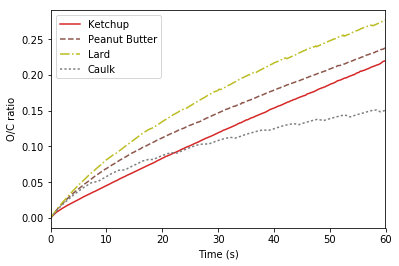

In [8]:
%matplotlib inline
# Plot of average O/C ratio for each material.

fig, ax = plt.subplots(1)

prop_cycle = cycler('color', ['tab:red', 'tab:brown', 'tab:olive', 'tab:gray']) + \
                cycler('linestyle', ['-', '--', '-.', ':'])

ax.set_prop_cycle(prop_cycle)

for simulation in averages.values():
    simulation.plot(x = "Time (s)", y = "O/C ratio", ax = ax)

ax.set_ylabel("O/C ratio")

ax.legend(averages.keys())

plt.show()

Based on these results, when going from a consistency of ketchup to peanut butter to lard, the aerosol becomes *more* oxidized (i.e., the O/C ratio increases more) as the material gets stiffer. In other words, limiting the movement of the oxidants to the surface appears to actually enhance the oxidation reactions started by OH radicals. This effect has a limit, however. If the material gets as stiff as caulk, the O/C ratio does not increase nearly as much as any of the other materials by the end of the oxidation. 

Examining the O/C ratio as a function of time and distance from the center of the aerosol particle through a contour map reveals why this might be the case.

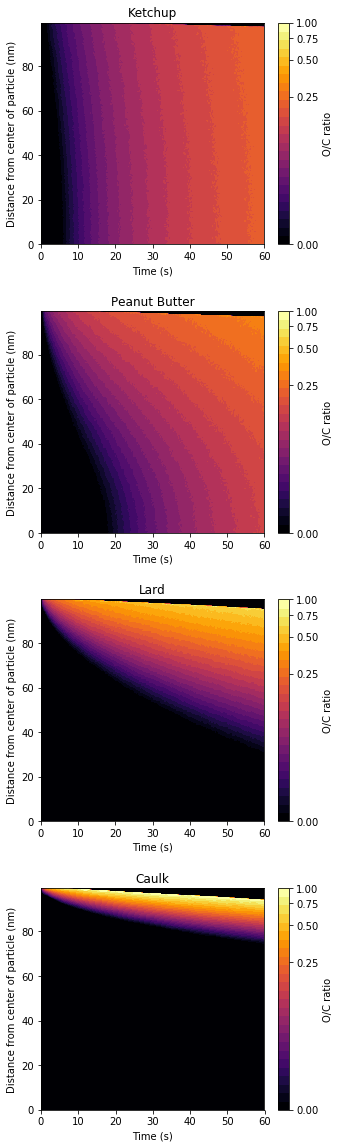

In [29]:
%matplotlib inline

# Plot contour maps of O/C ratio for each simulation

N_levels = 26
  
levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.linspace(0, 1, num = 5)
    
cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(4, 1, figsize=(5, 20))

plt.subplots_adjust(hspace=0.3)

i = 0

axes[0].set_xlim([0, 60])

for name, data in contours.items():
    contf = axes[i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap = cmap, norm = norm, spacing = 'uniform')
    cb = fig.colorbar(contf, ax=axes[i], ticks=labels)
    cb.set_label("O/C ratio")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Distance from center of particle (nm)")
    axes[i].set_title(name)
    i += 1
    


Here, the black is unoxidzied material, and the colors going from purple to orange to yellow represent increased oxidation on a log scale. The vertical axis for each represents the distance from the center along the radius of the (100 nanometer radius) particle. 

The aerosol material with the consitency of ketchup, being much more fluid, shows oxidation throughout the entire material as reaction products can easily travel from the surface inward. As the material becomes more thick and solid, the oxidized products cannot travel inward and become trapped at the surface. As such, the caulk-like material has a high O/C ratio near the surface, but the rest of the material has not reacted. 

Initially, some confinement near the surface helps promote oxidation because some of the produced products (like a type of chemical called an aldehyde) are more reactive than the starting material. Consequently, more oxidation is promoted in the aerosol. However, if the consistency gets too high, unreactive products (such as carboxylic acids and ketones) get trapped near the surface. This prevents OH at the surface from reacting with the reactive material underneath.

## Additional notebooks

A more detailed description of the postprocessing can be found in Postprocessing.ipynb and StackSim.py. A more comprehensive comparison of material consistency (and diffusion, the ability of molecules to move in a subtance) and oxidant concentration can be found in DiffusionSeries.ipynb. Finally, an examination at the difference between day and night chemistry and the effect of different oxidation pathways is found in Autoxidation.ipynb.